In [1]:
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import itertools
from tqdm.notebook import tqdm
from typing import Tuple

import pandas as pd
import sympy
from sympy import lambdify, Matrix, symbols, Symbol
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from cycler import cycler
from collections import defaultdict
import seaborn as sns

DARK_THEME = False

if DARK_THEME:
    plt.style.use("dark_background")
    plt.style.use("seaborn-dark-palette")
    state_color = "deepskyblue"
    arrow_color = "white"
else:
    plt.style.use("seaborn-bright")
    state_color = "navy"
    arrow_color = "black"

## Generate figure 3

Eq(Matrix([
[    Derivative(S, t)],
[  Derivative(U⋅S, t)],
[    Derivative(U, t)],
[  Derivative(S^‡, t)],
[Derivative(U⋅S^‡, t)],
[    Derivative(P, t)],
[  Derivative(U⋅P, t)],
[Derivative(P_tot, t)]]), Matrix([
[          -S*U*k_Sf - 1.0e-6*S + 10000000.0*S^‡ + 1000.0*U⋅S],
[               S*U*k_Sf - 1000.000001*U⋅S + 10000000.0*U⋅S^‡],
[         -S*U*k_Sf - S^‡*U*k_TSf + 1000.0*U⋅S + 1000.0*U⋅S^‡],
[1.0e-6*S - S^‡*U*k_TSf - 10000010000000.0*S^‡ + 1000.0*U⋅S^‡],
[           S^‡*U*k_TSf + 1.0e-6*U⋅S - 10000010001000.0*U⋅S^‡],
[               -P*U*k_Pf + 10000000000000.0*S^‡ + 1000.0*U⋅P],
[              P*U*k_Pf - 1000.0*U⋅P + 10000000000000.0*U⋅S^‡],
[               10000000000000.0*S^‡ + 10000000000000.0*U⋅S^‡]]))

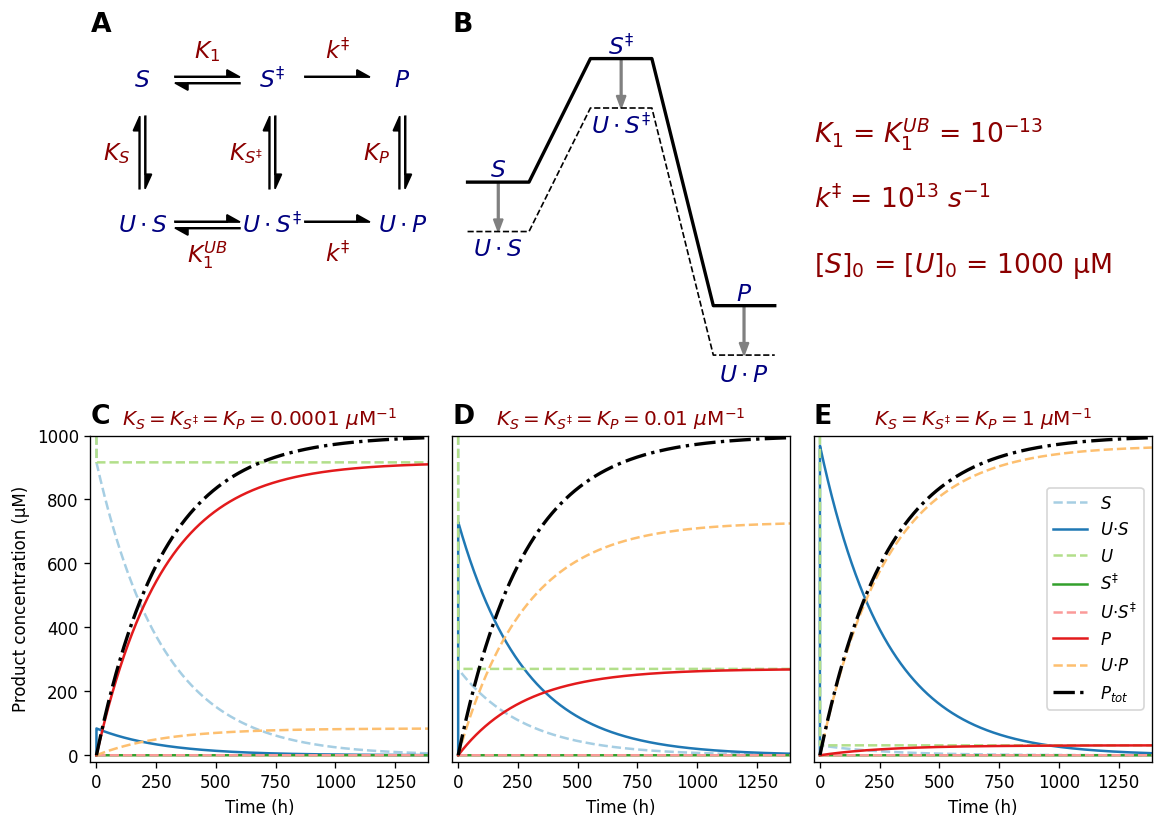

In [2]:
default_cycler = (
    cycler(color=sns.color_palette("Paired", n_colors=7).as_hex() + [arrow_color]) +
    cycler(linestyle=['--', '-', '--', '-', '--', '-', '--', '-.']) +
    cycler(linewidth=[1.5]*7 + [2])
)
plt.rc('axes', prop_cycle=default_cycler)

fig, axs = plt.subplots(2, 3, figsize=(10, 7), dpi=120)

for ax in axs[0, :].flat:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)


ax = axs[0, 0]
ax.set_xlim(-0.4, 2.2)
ax.set_ylim(-1, 1.25)

state_params = {'ha': 'center', 'va': 'center', 'color': state_color, 'fontsize': 14}
kinetic_params = {'ha': 'center', 'va': 'center', 'color': 'darkred', 'fontsize': 14}
arrow_params = {'length_includes_head': True, 'shape': 'right', 'head_starts_at_zero': True,
                "fc": arrow_color, "ec": arrow_color, "width": 0.01, "head_width": 0.1, "head_length": 0.1}

# states
ax.text(0, 1, '$S$', **state_params)           # S
ax.text(1, 1, '$S^‡$', **state_params)         # S‡
ax.text(0, 0, '$U \cdot S$', **state_params)   # US
ax.text(1, 0, '$U \cdot S^‡$', **state_params) # U*S‡
ax.text(2, 1, '$P$', **state_params)           # P
ax.text(2, 0, '$U \cdot P$', **state_params)   # UP

# arrows
ax.arrow(-0.02, 0.2, 0, 0.5, **arrow_params)  # U*S -> S
ax.arrow(0.02, 0.8, 0, -0.5, **arrow_params)  # S -> U*S
ax.arrow(0.98, 0.2, 0, 0.5, **arrow_params)   # U*S‡ -> S‡
ax.arrow(1.02, 0.8, 0, -0.5, **arrow_params)  # S‡ -> U*S‡
ax.arrow(1.98, 0.2, 0, 0.5, **arrow_params)   # U*P -> P
ax.arrow(2.02, 0.8, 0, -0.5, **arrow_params)  # P -> U*P

ax.arrow(0.2, 0.02, 0.5, 0, **arrow_params)   # U*S -> U*S‡
ax.arrow(0.8, -0.02, -0.5, 0, **arrow_params) # U*S‡ -> U*S
ax.arrow(0.2, 1.02, 0.5, 0, **arrow_params)   # S -> S‡
ax.arrow(0.8, 0.98, -0.5, 0, **arrow_params)  # S‡ -> S
ax.arrow(1.2, 1.02, 0.5, 0, **arrow_params)   # S‡ -> P
ax.arrow(1.2, 0.02, 0.5, 0, **arrow_params)   # U*S‡ -> U*P

# kinetic parameters
ax.text(0.5, -0.2, '$K_1^{UB}$', **kinetic_params)  # K_1^unib
ax.text(0.5, 1.2, '$K_1$', **kinetic_params)        # K_1
ax.text(-0.2, 0.5, '$K_S$', **kinetic_params)       # K_S
ax.text(0.8, 0.5, '$K_{S^‡}$', **kinetic_params)    # K_S^‡
ax.text(1.8, 0.5, '$K_P$', **kinetic_params)    # K_P
ax.text(1.5, 1.2, '$k^‡$', **kinetic_params)          # k
ax.text(1.5, -0.2, '$k^‡$', **kinetic_params)         # k

# Subfigure B - energy plot
ax = axs[0, 1]
ax.plot(np.linspace(0, 1, 6), [0.5, 0.5, 1.0, 1.0, 0.0, 0.0], '-', color=arrow_color, linewidth=2)
ax.plot(np.linspace(0, 1, 6), [0.3, 0.3, 0.8, 0.8, -0.2, -0.2], '--', color=arrow_color, linewidth=1)

# states
ax.text(0.1, 0.55, '$S$', **state_params)           # S
ax.text(0.5, 1.05, '$S^‡$', **state_params)         # S‡
ax.text(0.9, 0.05, '$P$', **state_params)           # P
ax.text(0.1, 0.23, '$U \cdot S$', **state_params)   # U*S
ax.text(0.5, 0.73, '$U \cdot S^‡$', **state_params) # U*S‡
ax.text(0.9, -0.28, '$U \cdot P$', **state_params)  # U*P

# arrows
arrow_params = {'length_includes_head': True, 'head_starts_at_zero': False,
                "fc": "grey", "ec": "grey", "width": 0.005, "head_width": 0.03, "head_length": 0.05}
ax.arrow(0.1, 0.5, 0, -0.2, **arrow_params)  # S -> U*S
ax.arrow(0.5, 1.0, 0, -0.2, **arrow_params)  # S‡ -> U*S‡
ax.arrow(0.9, 0.0, 0, -0.2, **arrow_params)  # P -> U*P


y = S, U_S, U, TS, U_TS, P, U_P, P_tot = sympy.symbols("S U⋅S U S^‡ U⋅S^‡ P U⋅P P_tot")
k_Sf, k_Sr, k_TSf, k_TSr, k_Pf, k_Pr, k_nonf, k_nonr, k_unibf, k_unibr, k_chem = sympy.symbols("k_Sf, k_Sr, k_TSf, k_TSr, k_Pf, k_Pr, k_nonf, k_nonr, k_unibf, k_unibr, k_chem")
t = sympy.symbols("t")

derivatives = {
    S:     -k_Sf * S * U - k_nonf * S + k_Sr * U_S + k_nonr * TS,
    U:     -k_Sf * S * U - k_TSf * TS * U + k_Sr * U_S + k_TSr * U_TS,
    TS:    -k_nonr * TS - k_TSf * TS * U + k_nonf * S + k_TSr * U_TS - k_chem * TS,
    U_S :  -k_Sr * U_S - k_unibf * U_S + k_Sf * S * U + k_unibr * U_TS,
    U_TS:  -k_unibr * U_TS - k_TSr * U_TS + k_unibf * U_S + k_TSf * TS * U - k_chem * U_TS,
    P:     -k_Pf * P * U + k_Pr * U_P + k_chem * TS,
    U_P:   -k_Pr * U_P + k_Pf * P * U + k_chem * U_TS,
    P_tot:  k_chem * (TS + U_TS)
}
dy_dt = sympy.Matrix([derivatives[symb] for symb in y], ndmin=1)
symbolic_dy_dt = sympy.Matrix([sympy.Derivative(symb, t) for symb in y], ndmin=1)

k_ddagger = 1e13
K1 = 1e-18

# k_cat = K1 * k_ddagger => K1 = k_cat/k_ddagger = 10 / 1e13 = 1e-12

# k_nonf = 1e-6, k_nonr = 1e6


assignments = {
    k_Sr: 1e3,  # 1/s
    k_TSr: 1e3, # 1/s
    k_Pr: 1e3,
    k_nonf: 1e-6, # 1/s
    k_nonr: 1e7, # 1/s
    k_unibf: 1e-6, # 1/s (= k_nonf)
    k_unibr: 1e7, # 1/s (= k_nonr)
    k_chem: 1e13, # 1/s
}

initial_concentrations = defaultdict(float)
initial_concentrations[S] = 1e3 # μM
initial_concentrations[U] = 1e3 # μM

dy_dt = dy_dt.subs(assignments)
display(sympy.Eq(symbolic_dy_dt, dy_dt))

def integrate(dy_dt: sympy.Matrix, max_t: float) -> np.ndarray:
    """
        
        x - anti-catalysis level (ratio of kQ_unib to kQ_non)
    """
    J_func = sympy.lambdify((y, t), dy_dt)
    J2_func = lambda y, t: J_func(y, t).flatten()

    tout = np.linspace(0, max_t, 10000)
    y_init = [initial_concentrations[symb] for symb in y]
    y_odeint = odeint(J2_func, y_init, tout)
    return tout, y_odeint

for ax, K_S, max_t in zip(axs[1, :].flat, [1e-4, 1e-2, 1], [5e6]*3):
    tout, y_odeint = integrate(dy_dt.subs({
        k_Sf: K_S * 1e3, # 1/s/uM (= K_S * k_Sr)
        k_TSf: K_S * 1e3, # 1/s/uM (= K_TS * k_TSr)
        k_Pf: K_S * 1e3, # 1/s/uM (= K_P * k_Pr)
    }), max_t)
    ax.plot(tout/3600.0, y_odeint)
    ax.set_title(f"$K_S = K_{{S^‡}} = K_P = {K_S:.1g}$" + r" $μΜ^{-1}$", color="darkred")
    ax.set_xlim(-max_t/2e5, max(tout/3600.0))
    ax.set_xlabel("Time (h)")
    ax.set_ylim(-20, 1e3)

axs[1, 0].set_ylabel("Product concentration (μM)")
axs[1, 1].set_yticks([])
axs[1, 2].set_yticks([])
axs[1, 2].legend([f"${sympy.latex(symb)}$" for symb in y])

subfigure_text_args = {"fontsize": 16, "ha": "left", "va": "bottom", "fontweight": "bold"}
axs[0, 0].text(0, 1.02, "A", transform=axs[0, 0].transAxes, **subfigure_text_args)
axs[0, 1].text(0, 1.02, "B", transform=axs[0, 1].transAxes, **subfigure_text_args)
axs[1, 0].text(0, 1.02, "C", transform=axs[1, 0].transAxes, **subfigure_text_args)
axs[1, 1].text(0, 1.02, "D", transform=axs[1, 1].transAxes, **subfigure_text_args)
axs[1, 2].text(0, 1.02, "E", transform=axs[1, 2].transAxes, **subfigure_text_args)

# subfigure C: values for kinetic parameters
ax = axs[0, 2]
ax.text(0, 0.7, f"$K_1$ = $K_1^{{UB}}$ = $10^{{{np.log10(assignments[k_nonf] / assignments[k_nonr]):g}}}$", color="darkred", fontsize=16)
ax.text(0, 0.5, f"$k^‡$ = $10^{{{np.log10(assignments[k_chem]):g}}}$ $s^{{-1}}$", color="darkred", fontsize=16)
ax.text(0, 0.3, f"$[S]_0$ = $[U]_0$ = 1000 µM", color="darkred", fontsize=16)

fig.tight_layout()
fig.savefig("figures/figure3.svg")

## Generate Figure 5

Eq(Matrix([
[    Derivative(S, t)],
[    Derivative(Q, t)],
[  Derivative(P_1, t)],
[  Derivative(P_2, t)],
[  Derivative(Q⋅S, t)],
[Derivative(Q⋅P_1, t)],
[Derivative(Q⋅P_2, t)]]), Matrix([
[                                              -Q*S*k_fast - S*k1_non - S*k2_non + Q⋅S*k_fast/K_S],
[-P_1*Q*k_fast - P_2*Q*k_fast - Q*S*k_fast + Q⋅S*k_fast/K_S + Q⋅P_2*k_fast/K_2 + Q⋅P_1*k_fast/K_1],
[                                                     -P_1*Q*k_fast + S*k1_non + Q⋅P_1*k_fast/K_1],
[                                                     -P_2*Q*k_fast + S*k2_non + Q⋅P_2*k_fast/K_2],
[                                             Q*S*k_fast - Q⋅S*k1_UB - Q⋅S*k2_NC - Q⋅S*k_fast/K_S],
[                                                     P_1*Q*k_fast + Q⋅S*k1_UB - Q⋅P_1*k_fast/K_1],
[                                                     P_2*Q*k_fast + Q⋅S*k2_NC - Q⋅P_2*k_fast/K_2]]))

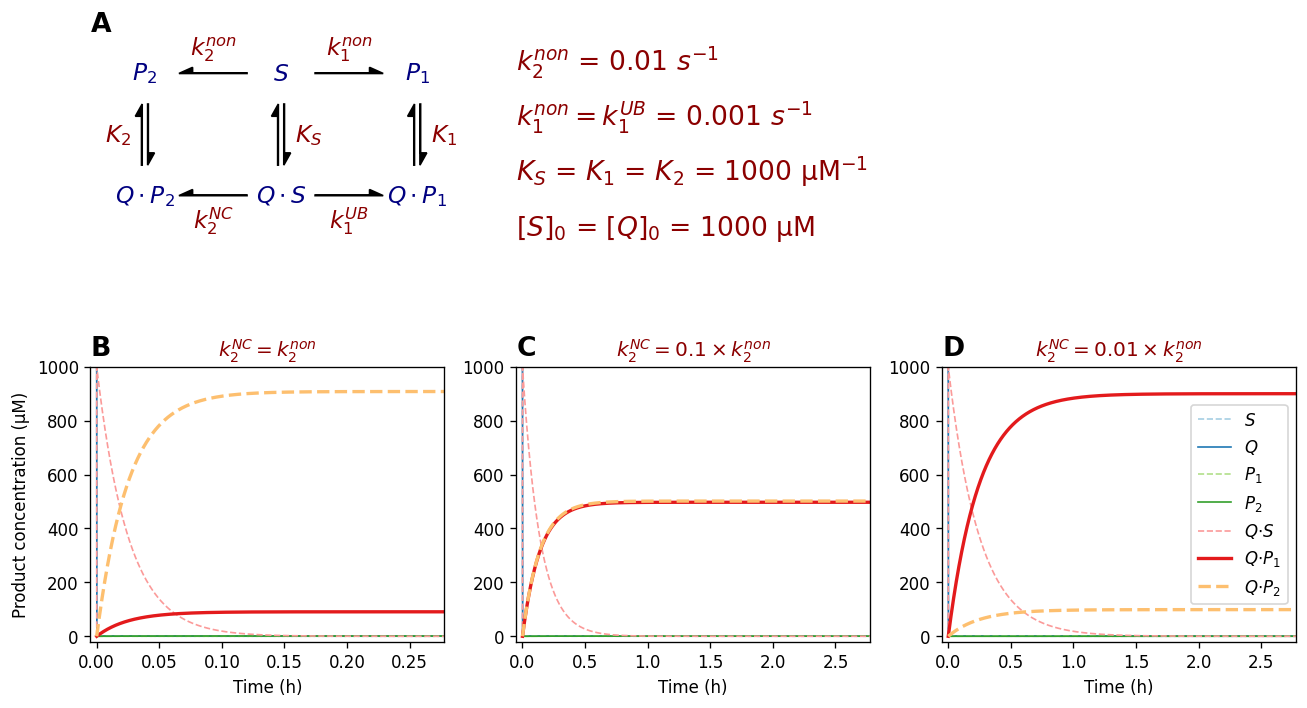

In [3]:
default_cycler = (
    cycler(color=sns.color_palette("Paired", n_colors=7).as_hex()) +
    cycler(linestyle=['--', '-', '--', '-', '--', '-', '--']) +
    cycler(linewidth=[1]*5 + [2]*2)
)
plt.rc('axes', prop_cycle=default_cycler)

fig, axs = plt.subplots(2, 3, figsize=(11, 6), dpi=120)

for ax in axs[0, :].flat:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

ax = axs[0, 0]
ax.set_xlim(-0.4, 2.2)
ax.set_ylim(-1, 1.25)

state_params = {'ha': 'center', 'va': 'center', 'color': state_color, 'fontsize': 14}
kinetic_params = {'ha': 'center', 'va': 'center', 'color': 'darkred', 'fontsize': 14}
arrow_params_r = {'length_includes_head': True, 'shape': 'right', 'head_starts_at_zero': True,
                  "fc": arrow_color, "ec": arrow_color, "width": 0.01, "head_width": 0.1, "head_length": 0.1}
arrow_params_l = {'length_includes_head': True, 'shape': 'left', 'head_starts_at_zero': True,
                  "fc": arrow_color, "ec": arrow_color, "width": 0.01, "head_width": 0.1, "head_length": 0.1}

# states
ax.text(0, 1, '$P_2$', **state_params)
ax.text(1, 1, '$S$', **state_params)
ax.text(2, 1, '$P_1$', **state_params)
ax.text(0, 0, '$Q \cdot P_2$', **state_params)
ax.text(1, 0, '$Q \cdot S$', **state_params)
ax.text(2, 0, '$Q \cdot P_1$', **state_params)

# arrows
ax.arrow(-0.02, 0.2, 0, 0.5, **arrow_params_r)  # Q*P2 -> P2
ax.arrow(0.02, 0.8, 0, -0.5, **arrow_params_r)  # P2 -> Q*P2
ax.arrow(0.98, 0.2, 0, 0.5, **arrow_params_r)   # Q*S -> S
ax.arrow(1.02, 0.8, 0, -0.5, **arrow_params_r)  # S -> Q*S
ax.arrow(1.98, 0.2, 0, 0.5, **arrow_params_r)   # Q*P1 -> P1
ax.arrow(2.02, 0.8, 0, -0.5, **arrow_params_r)  # P1 -> Q*P1
ax.arrow(0.8, 1., -0.5, 0, **arrow_params_l)    # S -> P2
ax.arrow(1.2, 1., 0.5, 0, **arrow_params_r)     # S -> P1
ax.arrow(0.8, 0., -0.5, 0, **arrow_params_l)    # Q*S -> Q*P2
ax.arrow(1.2, 0., 0.5, 0, **arrow_params_r)     # Q*S -> Q*P1

# kinetic parameters
ax.text(0.5, -0.2, '$k_2^{NC}$', **kinetic_params)
ax.text(0.5, 1.2, '$k_2^{non}$', **kinetic_params)
ax.text(1.5, 1.2, '$k_1^{non}$', **kinetic_params)
ax.text(1.5, -0.2, '$k_1^{UB}$', **kinetic_params)

ax.text(-0.2, 0.5, '$K_2$', **kinetic_params) # K_P2
ax.text(1.2, 0.5, '$K_S$', **kinetic_params)  # K_S
ax.text(2.2, 0.5, '$K_1$', **kinetic_params)  # K_P1

y = S, Q, P1, P2, QS, QP1, QP2 = sympy.symbols("S Q P_1 P_2 Q⋅S Q⋅P_1 Q⋅P_2")
k1_non, k2_non, k2_NC, K_S, K_1, K_2, k_fast, k1_UB = sympy.symbols("k1_non k2_non k2_NC K_S K_1 K_2 k_fast k1_UB")
t = sympy.symbols("t")
symbolic_dy_dt = sympy.Matrix([sympy.Derivative(symb, t) for symb in y], ndmin=1)

initial_concentrations = defaultdict(float)
initial_concentrations[S] = 1000 # μM
initial_concentrations[Q] = 1000 # μM

uniform_affinity = 1e3
assignments = {
    k1_non : 1e-3, # 1/s
    k2_non : 1e-2, # 1/s
    K_S : uniform_affinity, # 1/μM
    K_1 : uniform_affinity, # 1/μM
    K_2 : uniform_affinity, # 1/μM
    k_fast : 1e4, # 1/s a large rate constant (for the fast equilibrium of S<->US, P<->UP, Q<->UQ)
    k1_UB : 1e-3, # 1/s ( = k1_non ) uniform binding assumtion
}

derivatives = {
    S:  -k2_non * S      - k_fast * S * Q   + k_fast * QS/K_S - k1_non * S,
    P2:  k2_non * S      - k_fast * P2 * Q  + k_fast * QP2/K_2,
    P1:  k1_non * S      - k_fast * P1 * Q  + k_fast * QP1/K_1,
    Q:  -k_fast * S * Q  - k_fast * P1 * Q  - k_fast * P2 * Q + k_fast * QS/K_S + k_fast * QP1/K_1 + k_fast * QP2/K_2,
    QS:  k_fast * S * Q  - k_fast * QS/K_S  - k1_UB * QS - k2_NC * QS,
    QP2: k_fast * P2 * Q - k_fast * QP2/K_2              + k2_NC * QS,
    QP1: k_fast * P1 * Q - k_fast * QP1/K_1 + k1_UB * QS,
}
dy_dt = sympy.Matrix([derivatives[symb] for symb in y], ndmin=1)
display(sympy.Eq(symbolic_dy_dt, dy_dt))

def integrate(x: float, max_t: float) -> np.ndarray:
    """
        
        x - anti-catalysis level (ratio of kQ_unib to kQ_non)
    """ 
    J_func = sympy.lambdify((y, t), dy_dt.subs(assignments).subs({k2_NC: x}))
    J2_func = lambda y, t: J_func(y, t).flatten()

    tout = np.linspace(0, max_t, 10000)
    y_init = [initial_concentrations[symb] for symb in y]
    y_odeint = odeint(J2_func, y_init, tout)
    return tout, y_odeint

for ax, x, max_t in zip(axs[1,:].flat, [1e-2, 1e-3, 1e-4], [1e3, 1e4, 1e4]):
    tout, y_odeint = integrate(x, max_t)
    ax.plot(tout/3600.0, y_odeint)
    ax.set_xlim(-max_t/2e5, max(tout/3600.0))
    ax.set_xlabel("Time (h)")
    ax.set_ylim(-20, 1e3)
    
axs[1,0].set_ylabel("Product concentration (μM)")
axs[1,0].set_title(r"$k_2^{NC} = k_2^{non}$", color="darkred")
axs[1,1].set_title(r"$k_2^{NC} = 0.1 \times k_2^{non}$", color="darkred")
axs[1,2].set_title(r"$k_2^{NC} = 0.01 \times k_2^{non}$", color="darkred")
axs[1,2].legend([f"${sympy.latex(symb)}$" for symb in y]);

subfigure_text_args = {"fontsize": 16, "ha": "left", "va": "bottom", "fontweight": "bold"}
axs[0, 0].text(0, 1.02, "A", transform=axs[0, 0].transAxes, **subfigure_text_args)
axs[1, 0].text(0, 1.02, "B", transform=axs[1, 0].transAxes, **subfigure_text_args)
axs[1, 1].text(0, 1.02, "C", transform=axs[1, 1].transAxes, **subfigure_text_args)
axs[1, 2].text(0, 1.02, "D", transform=axs[1, 2].transAxes, **subfigure_text_args)

# subfigure B: values for kinetic parameters

# [S]0 = [Q]0 = 1000 µM; KS = K1 = K2 = 1000 μM-1.

ax = axs[0, 1]
ax.text(0, 0.9, f"$k_2^{{non}}$ = {assignments[k2_non]:g} $s^{{-1}}$", color="darkred", fontsize=16)
ax.text(0, 0.7, f"$k_1^{{non}} = k_1^{{UB}}$ = {assignments[k1_non]:g} $s^{{-1}}$", color="darkred", fontsize=16)
ax.text(0, 0.5, f"$K_S$ = $K_1$ = $K_2$ = {uniform_affinity:g} μM$^{{-1}}$", color="darkred", fontsize=16)
ax.text(0, 0.3, f"$[S]_0$ = $[Q]_0$ = 1000 µM", color="darkred", fontsize=16)

fig.tight_layout()
fig.savefig("figures/figure5.svg")

## Generate Figure 6

Eq(Matrix([
[  Derivative(P^*, t)],
[Derivative(Q⋅P_2, t)],
[Derivative(Q⋅P_1, t)],
[  Derivative(Q⋅S, t)],
[  Derivative(P_1, t)],
[    Derivative(Q, t)],
[  Derivative(P_2, t)],
[    Derivative(S, t)]]), Matrix([
[                                                                       0.1*P_1],
[                                        10000.0*P_2*Q - 1.0*Q⋅P_2 + 1.0e-5*Q⋅S],
[                                         10000.0*P_1*Q - 1.0*Q⋅P_1 + 0.001*Q⋅S],
[                                                     10000.0*Q*S - 1.00101*Q⋅S],
[                                -10000.0*P_1*Q - 0.1*P_1 + 1.0*Q⋅P_1 + 0.001*S],
[-10000.0*P_1*Q - 10000.0*P_2*Q - 10000.0*Q*S + 1.0*Q⋅P_1 + 1.0*Q⋅P_2 + 1.0*Q⋅S],
[                                           -10000.0*P_2*Q + 1.0*Q⋅P_2 + 0.01*S],
[                                              -10000.0*Q*S + 1.0*Q⋅S - 0.011*S]]))

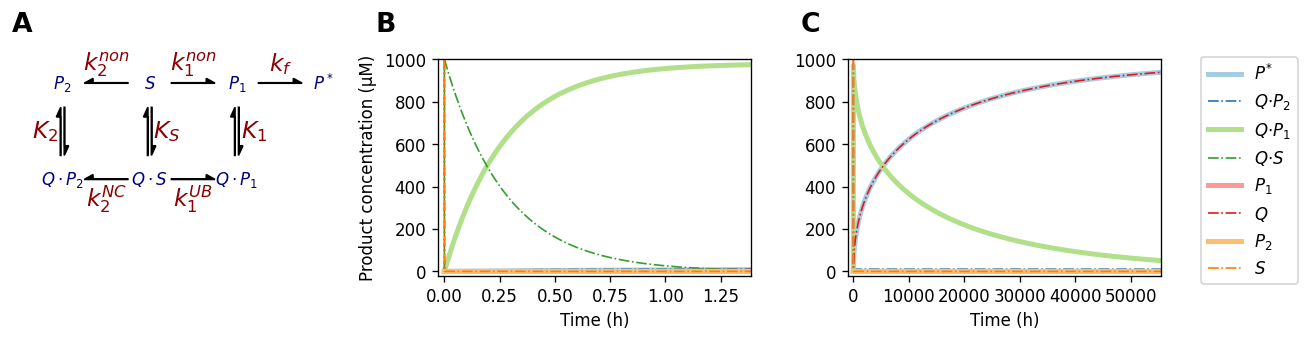

In [4]:
default_cycler = (
    cycler(color=sns.color_palette("Paired", n_colors=8).as_hex()) +
    cycler(linestyle=['-', '-.']*4) +
    cycler(linewidth=[3, 1]*4)
)
plt.rc('axes', prop_cycle=default_cycler)

fig, axs = plt.subplots(1, 3, figsize=(11, 3), dpi=120)

for ax in axs[0:1].flat:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

ax = axs[0]
ax.set_xlim(-0.4, 3.2)
ax.set_ylim(-1, 1.25)

state_params = {'ha': 'center', 'va': 'center', 'color': state_color, 'fontsize': 10}
kinetic_params = {'ha': 'center', 'va': 'center', 'color': 'darkred', 'fontsize': 14}
arrow_params_r = {'length_includes_head': True, 'shape': 'right', 'head_starts_at_zero': True,
                  "fc": arrow_color, "ec": arrow_color, "width": 0.01, "head_width": 0.1, "head_length": 0.1}
arrow_params_l = {'length_includes_head': True, 'shape': 'left', 'head_starts_at_zero': True,
                  "fc": arrow_color, "ec": arrow_color, "width": 0.01, "head_width": 0.1, "head_length": 0.1}

# states
ax.text(0, 1, '$P_2$', **state_params)
ax.text(1, 1, '$S$', **state_params)
ax.text(2, 1, '$P_1$', **state_params)
ax.text(3, 1, '$P^*$', **state_params)
ax.text(0, 0, '$Q \cdot P_2$', **state_params)
ax.text(1, 0, '$Q \cdot S$', **state_params)
ax.text(2, 0, '$Q \cdot P_1$', **state_params)

# arrows
ax.arrow(-0.02, 0.2, 0, 0.5, **arrow_params_r)  # Q*P2 -> P2
ax.arrow(0.02, 0.8, 0, -0.5, **arrow_params_r)  # P2 -> Q*P2
ax.arrow(0.98, 0.2, 0, 0.5, **arrow_params_r)   # Q*S -> S
ax.arrow(1.02, 0.8, 0, -0.5, **arrow_params_r)  # S -> Q*S
ax.arrow(1.98, 0.2, 0, 0.5, **arrow_params_r)   # Q*P1 -> P1
ax.arrow(2.02, 0.8, 0, -0.5, **arrow_params_r)  # P1 -> Q*P1

ax.arrow(0.8, 1., -0.5, 0, **arrow_params_l)    # S -> P2
ax.arrow(1.2, 1., 0.5, 0, **arrow_params_r)     # S -> P1
ax.arrow(2.2, 1., 0.5, 0, **arrow_params_r)     # P1 -> P*

ax.arrow(0.8, 0., -0.5, 0, **arrow_params_l)    # Q*S -> Q*P2
ax.arrow(1.2, 0., 0.5, 0, **arrow_params_r)     # Q*S -> Q*P1

# kinetic parameters
ax.text(0.5, -0.2, '$k_2^{NC}$', **kinetic_params)
ax.text(0.5, 1.2, '$k_2^{non}$', **kinetic_params)
ax.text(1.5, 1.2, '$k_1^{non}$', **kinetic_params)
ax.text(2.5, 1.2, '$k_f$', **kinetic_params)
ax.text(1.5, -0.2, '$k_1^{UB}$', **kinetic_params)

ax.text(-0.2, 0.5, '$K_2$', **kinetic_params) # K_P2
ax.text(1.2, 0.5, '$K_S$', **kinetic_params)  # K_S
ax.text(2.2, 0.5, '$K_1$', **kinetic_params)  # K_P1

y = Pstar, QP2, QP1, QS, P1, Q, P2, S = sympy.symbols("P^* Q⋅P_2 Q⋅P_1 Q⋅S P_1 Q P_2 S")
k1_non, k2_non, K_S, K_1, K_2, k_fast, k1_UB, k2_NC, k_f = sympy.symbols("k1_non k2_non K_S K_1 K_2 k_fast k1_UB k2_NC k_f")
t = sympy.symbols("t")
symbolic_dy_dt = sympy.Matrix([sympy.Derivative(symb, t) for symb in y], ndmin=1)

initial_concentrations = defaultdict(float)
initial_concentrations[S] = 1000 # μM
initial_concentrations[Q] = 1000 # μM - instead of 1000 to see the trajectories better (otherwise overlaps with P*)

assignments = {
    k2_non : 1e-2, # 1/s
    k1_non : 1e-3, # 1/s
    K_S : 1e4, # 1/μM
    K_1 : 1e4, # 1/μM
    K_2 : 1e4, # 1/μM
    k_fast : 1e4, # 1/s a large rate constant (for the fast equilibrium of S<->QS, P1<->QP1, P2<->QP2)
    k1_UB : 1e-3, # 1/s ( = kP_non ) uniform binding assumtion
    k2_NC : 1e-5, # 1/s
    k_f : 0.1, # 1/s
}

derivatives = {
    S: -k2_non  * S - k_fast * S * Q + k_fast * QS/K_S - k1_non * S,
    P2:  k2_non  * S - k_fast * P2 * Q + k_fast * QP2/K_2,
    P1:  k1_non  * S - k_fast * P1 * Q + k_fast * QP1/K_1 - k_f * P1,
    Pstar: k_f * P1,
    Q: -k_fast * S * Q - k_fast  * P1 * Q - k_fast * P2 * Q + k_fast * QS/K_S + k_fast * QP1/K_1 + k_fast * QP2/K_2,
    QS:  k_fast * S * Q - k_fast * QS/K_S - k2_NC * QS - k1_UB * QS,
    QP2:  k_fast * P2 * Q - k_fast * QP2/K_2 + k2_NC * QS,
    QP1:  k_fast * P1 * Q - k_fast * QP1/K_1 + k1_UB * QS,
}

dy_dt = sympy.Matrix([derivatives[symb] for symb in y], ndmin=1)
dy_dt = dy_dt.subs(assignments)
display(sympy.Eq(symbolic_dy_dt, dy_dt))
J_func = sympy.lambdify((y, t), dy_dt)
J2_func = lambda y, t: J_func(y, t).flatten()

ax = axs[1]

tout = np.linspace(0, 5000, 10000)
y_init = [initial_concentrations[symb] for symb in y]
y_odeint, info = odeint(J2_func, y_init, tout, mxstep=100000, full_output=True)
ax.plot(tout/3600, y_odeint)
ax.set_xlim(-0.03, max(tout/3600.0))
ax.set_xlabel("Time (h)")
ax.set_ylim(-20, 1e3)

ax.set_ylabel("Product concentration (μM)")

ax = axs[2]

tout = np.linspace(0, 2e8, 10000)
y_init = [initial_concentrations[symb] for symb in y]
y_odeint, info = odeint(J2_func, y_init, tout, mxstep=100000, full_output=True)
ax.plot(tout/3600, y_odeint)
ax.set_xlim(-1000, max(tout/3600.0))
ax.set_xlabel("Time (h)")
ax.set_ylim(-20, 1e3)



ax.legend([f"${sympy.latex(symb)}$" for symb in y], bbox_to_anchor=(1.1, 1.05));

subfigure_text_args = {"fontsize": 16, "ha": "left", "va": "bottom", "fontweight": "bold"}
axs[0].text(-0.05, 1.1, "A", transform=axs[0].transAxes, **subfigure_text_args)
axs[1].text(-0.2, 1.1, "B", transform=axs[1].transAxes, **subfigure_text_args)
axs[2].text(-0.15, 1.1, "C", transform=axs[2].transAxes, **subfigure_text_args)

fig.tight_layout()
fig.savefig("figures/figure6.svg")

## Criterion for rate maximization by uniform binding (Haldane rate law)

In [5]:
k_1f, k_2f, k_3f, k_1r, k_2r, k_3r = sympy.symbols("k_1 k_2 k_3 k_{-1} k_{-2} k_{-3}")
S, P, E = sympy.symbols("S P E_0")
omega = sympy.Symbol("ω")
k_catf = k_2f*k_3f/(k_2f + k_2r + k_3f)
k_catr = k_1r*k_2r/(k_2f + k_2r + k_1r)
K_S = (k_1r * k_2r + k_1r * k_3f + k_2f * k_3f) / (k_1f * (k_2f + k_2r + k_3f))
K_P = (k_1r * k_2r + k_1r * k_3f + k_2f * k_3f) / (k_3r * (k_2f + k_2r + k_1r))
K_eq = k_1f * k_2f * k_3f / k_1r / k_2r / k_3r
v_haldane = E * k_catf * (S / K_S) / (1 + S / K_S + P / K_P) * (1 - P/S/K_eq)


print("\n\nThe general reversible Haldane rate law:")
display(sympy.Equality(sympy.Symbol("v"), v_haldane))


v_prime = v_haldane.subs({k_1r: k_1r*sympy.exp(-omega), k_3f: k_3f*sympy.exp(-omega)})
print("\n\nThe new rate given uniform binding with energy ω:")
display(sympy.Equality(sympy.Symbol("v'"), v_prime))


dlnv_dw = sympy.simplify(sympy.diff(sympy.log(v_prime), omega))
print("\n\nTaking the derivative of the log-scaled rate w.r.t. ω:")
display(sympy.Equality(sympy.Derivative(sympy.log(sympy.Symbol("v'")), omega), dlnv_dw))


print("\n\nSolve dlog(v')/dω = 0 in order to find the uniform binding strength maximizing the rate:")
solutions = sympy.solve(dlnv_dw, omega)
display(sympy.Equality(sympy.exp(2*omega), sympy.exp(2*solutions[1])))



The general reversible Haldane rate law:


Eq(v, E_0*S*k_1*k_2*k_3*(-P*k_{-1}*k_{-2}*k_{-3}/(S*k_1*k_2*k_3) + 1)/((k_2*k_3 + k_3*k_{-1} + k_{-1}*k_{-2})*(P*k_{-3}*(k_2 + k_{-1} + k_{-2})/(k_2*k_3 + k_3*k_{-1} + k_{-1}*k_{-2}) + S*k_1*(k_2 + k_3 + k_{-2})/(k_2*k_3 + k_3*k_{-1} + k_{-1}*k_{-2}) + 1)))



The new rate given uniform binding with energy ω:


Eq(v', E_0*S*k_1*k_2*k_3*(-P*k_{-1}*k_{-2}*k_{-3}/(S*k_1*k_2*k_3) + 1)*exp(-ω)/((k_2*k_3*exp(-ω) + k_3*k_{-1}*exp(-2*ω) + k_{-1}*k_{-2}*exp(-ω))*(P*k_{-3}*(k_2 + k_{-1}*exp(-ω) + k_{-2})/(k_2*k_3*exp(-ω) + k_3*k_{-1}*exp(-2*ω) + k_{-1}*k_{-2}*exp(-ω)) + S*k_1*(k_2 + k_3*exp(-ω) + k_{-2})/(k_2*k_3*exp(-ω) + k_3*k_{-1}*exp(-2*ω) + k_{-1}*k_{-2}*exp(-ω)) + 1)))



Taking the derivative of the log-scaled rate w.r.t. ω:


Eq(Derivative(log(v'), ω), (-P*k_2*k_{-3}*exp(2*ω) - P*k_{-2}*k_{-3}*exp(2*ω) - S*k_1*k_2*exp(2*ω) - S*k_1*k_{-2}*exp(2*ω) + k_3*k_{-1})/(P*k_2*k_{-3}*exp(2*ω) + P*k_{-1}*k_{-3}*exp(ω) + P*k_{-2}*k_{-3}*exp(2*ω) + S*k_1*k_2*exp(2*ω) + S*k_1*k_3*exp(ω) + S*k_1*k_{-2}*exp(2*ω) + k_2*k_3*exp(ω) + k_3*k_{-1} + k_{-1}*k_{-2}*exp(ω)))



Solve dlog(v')/dω = 0 in order to find the uniform binding strength maximizing the rate:


Eq(exp(2*ω), k_3*k_{-1}/((k_2 + k_{-2})*(P*k_{-3} + S*k_1)))

## Figure S1

In [6]:
default_param_assignments = {
    "k1_non" : 1e-3, # 1/s
    "k2_non" : 1e-2, # 1/s
    "k2_NC" : 1e-3, # 1/s
    "K_S" : 1e3, # 1/μM
    "K_1" : 1e3, # 1/μM
    "K_2" : 1e3, # 1/μM
    "k_fast" : 1e4, # 1/s a large rate constant (for the fast equilibrium of S<->US, P<->UP, Q<->UQ)
    "k1_UB" : 1e-3, # 1/s ( = k1_non ) uniform binding assumtion
    "Q0": 1e3, # μM
    "S0": 1e3, # μM
}

In [7]:
def integrate(tout: np.ndarray, param_assignments: dict[str, float] = None) -> Tuple[Tuple[str], np.ndarray]:
    _d = default_param_assignments.copy()
    if param_assignments is not None:
        _d.update(param_assignments)
    param_assignments = _d

    y = S, Q, P1, P2, QS, QP1, QP2 = sympy.symbols("S Q P_1 P_2 Q⋅S Q⋅P_1 Q⋅P_2")
    p = k1_non, k2_non, k2_NC, K_S, K_1, K_2, k_fast, k1_UB = sympy.symbols("k1_non k2_non k2_NC K_S K_1 K_2 k_fast k1_UB")
    t = symbols("t")

    initial_concentrations = defaultdict(float)
    initial_concentrations[S] = param_assignments["S0"]
    initial_concentrations[Q] = param_assignments["Q0"]

    assignments = {}
    for param in p:
        assignments[param] = param_assignments[str(param)]
        
    derivatives = {
        S:  -k2_non * S      - k_fast * S * Q   + k_fast * QS/K_S - k1_non * S,
        P2:  k2_non * S      - k_fast * P2 * Q  + k_fast * QP2/K_2,
        P1:  k1_non * S      - k_fast * P1 * Q  + k_fast * QP1/K_1,
        Q:  -k_fast * S * Q  - k_fast * P1 * Q  - k_fast * P2 * Q + k_fast * QS/K_S + k_fast * QP1/K_1 + k_fast * QP2/K_2,
        QS:  k_fast * S * Q  - k_fast * QS/K_S  - k1_UB * QS - k2_NC * QS,
        QP2: k_fast * P2 * Q - k_fast * QP2/K_2              + k2_NC * QS,
        QP1: k_fast * P1 * Q - k_fast * QP1/K_1 + k1_UB * QS,
    }
    dy_dt = Matrix([derivatives[symb] for symb in y], ndmin=1)
    dy_dt = dy_dt.subs(assignments)
    J_func = lambdify((y, t), dy_dt)
    J2_func = lambda y, t: J_func(y, t).flatten()

    y_init = [initial_concentrations[symb] for symb in y]
    y_odeint, output = odeint(J2_func, y_init, tout, full_output = 1)
    return [str(s) for s in y], y_odeint, output

In [8]:
def calc_sensitivity(param_assignments: dict[str, float] = None) -> float:
    y, y_odeint, output = integrate(tout=np.linspace(0, 1e4, 20), param_assignments=param_assignments)
    P1_QP1 = y_odeint[-1, y.index("P_1")] + y_odeint[-1, y.index("Q⋅P_1")]
    P2_QP2 = y_odeint[-1, y.index("P_2")] + y_odeint[-1, y.index("Q⋅P_2")]
    return P1_QP1/(P1_QP1+P2_QP2)

In [9]:
range_Q0 = [100, 1000, 10000]
range_k2_NC = [1e-4, 1e-3, 1e-2]
range_binding = np.logspace(-2, 5, 20)
range_k_on = [1e2, 1e3, 1e4]

param_list = list(itertools.product(range_Q0, range_k2_NC, range_binding, range_k_on))

data = []
for Q0, k2_NC, binding, k_on in tqdm(param_list):
    p1_frac = calc_sensitivity({"Q0": Q0, "k2_NC": k2_NC, "K_S": binding, "K_1": binding, "K_2": binding, "k_fast": k_on})
    data.append((Q0, k2_NC, binding, k_on, p1_frac))

sensitivity_df = pd.DataFrame(data, columns=["Q0", "k2_NC", "uniform binding", "k_on", "fraction of P1 + QP1"])

  0%|          | 0/540 [00:00<?, ?it/s]

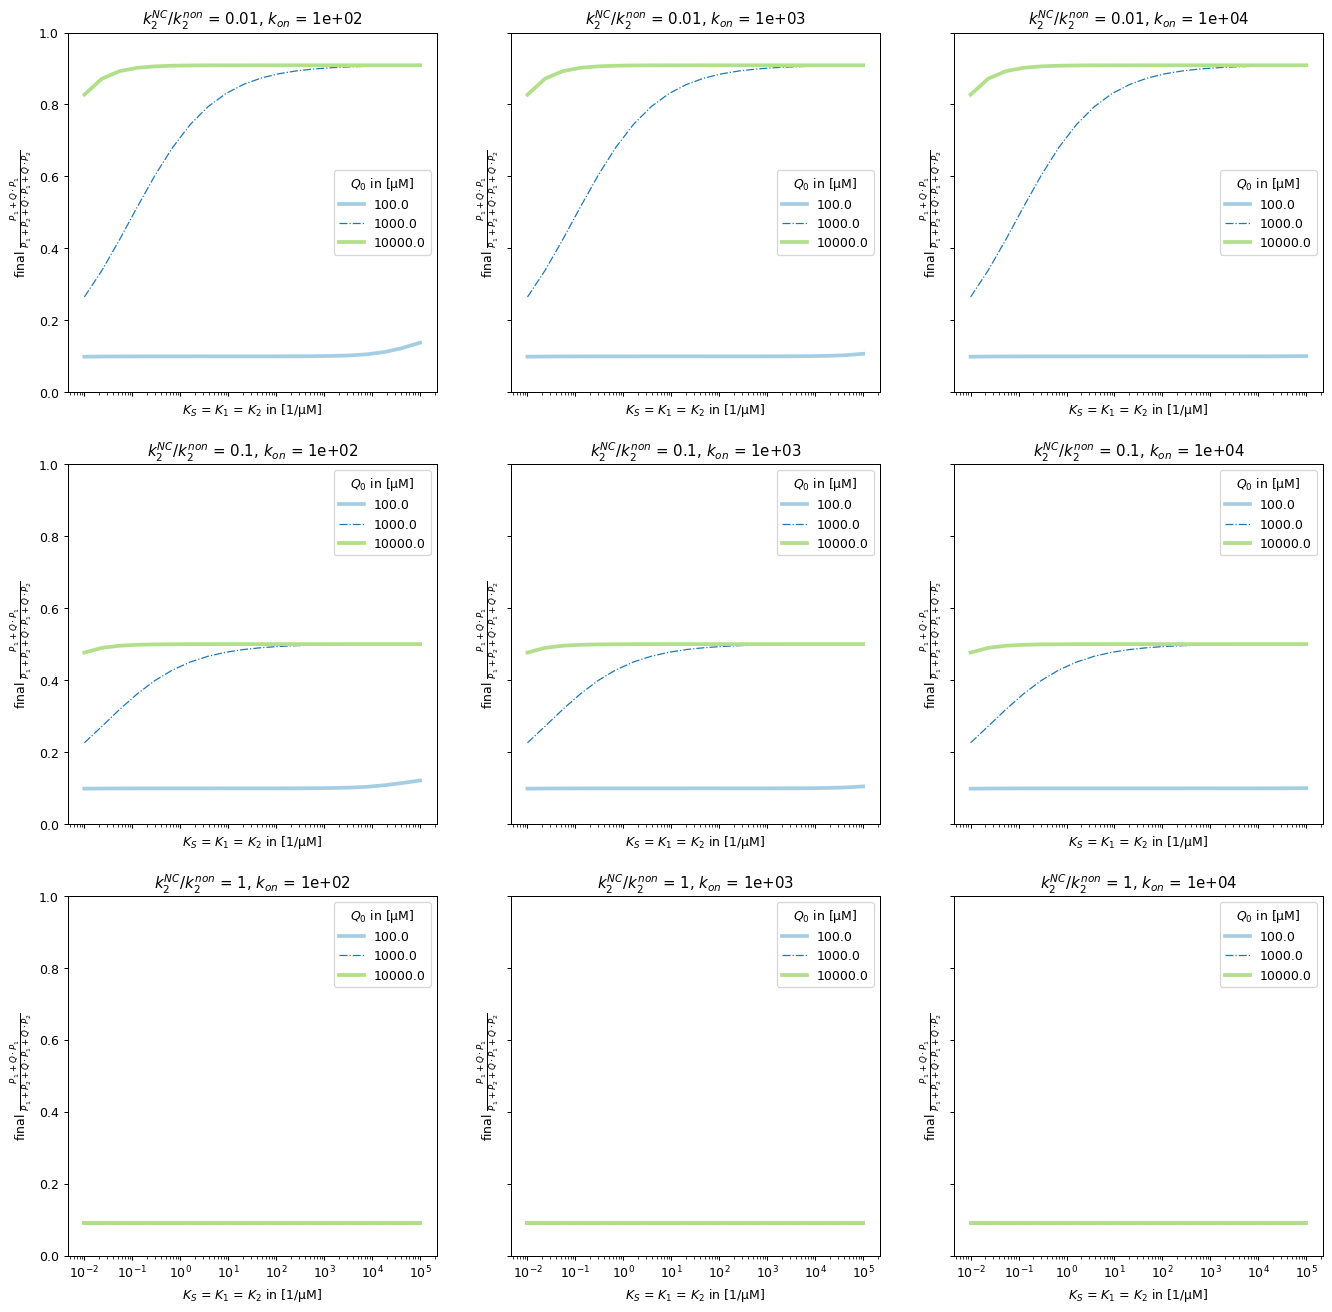

In [10]:
fig, axs = plt.subplots(3, 3, figsize=(18, 18), dpi=90, sharex=True, sharey=True)
for ax, ((k2_NC, k_on), group_df) in zip(axs.flat, sensitivity_df.groupby(["k2_NC", "k_on"])):
    for Q0, group2_df in group_df.groupby("Q0"):
        ax.plot(group2_df["uniform binding"], group2_df["fraction of P1 + QP1"], label=f"{Q0:.1f}")
    ax.legend(title="$Q_0$ in [μM]")
    ax.set_xlabel("$K_S$ = $K_1$ = $K_2$ in [1/μM]")
    ax.set_ylabel(r"final $\frac{P_1 + Q \cdot P_1}{P_1 + P_2 + Q \cdot P_1 + Q \cdot P_2}$")
    ax.set_title(f"$k_2^{{NC}} / k_2^{{non}}$ = {k2_NC/1e-2:.1g}, $k_{{on}}$ = {k_on:.1g}")
    ax.set_xscale("log")
    ax.set_ylim(0, 1)
    
fig.savefig("figures/figureS1.svg")

In [11]:
!inkscape --batch-process figures/figure1.svg -o figures/figure1.eps

In [12]:
!inkscape --batch-process figures/figure2.svg -o figures/figure2.eps

In [13]:
!inkscape --batch-process figures/figure3.svg -o figures/figure3.eps

In [14]:
!inkscape --batch-process figures/figure4.svg -o figures/figure4.eps

In [15]:
!inkscape --batch-process figures/figure5.svg -o figures/figure5.eps

In [25]:
!inkscape --batch-process figures/figure6.svg -o figures/figure6.eps

In [17]:
!inkscape --batch-process figures/figureS1.svg -o figures/figureS1.eps

In [18]:
!inkscape --batch-process figures/figure1.svg -o figures/figure1.png

Background RRGGBBAA: ffffff00
Area 0:0:872.858:791.611 exported to 873 x 792 pixels (96 dpi)


In [19]:
!inkscape --batch-process figures/figure2.svg -o figures/figure2.png

Background RRGGBBAA: ffffff00
Area 0:0:689.915:786.616 exported to 690 x 787 pixels (96 dpi)


In [20]:
!inkscape --batch-process figures/figure3.svg -o figures/figure3.png

Background RRGGBBAA: ffffff00
Area 0:0:960:672 exported to 960 x 672 pixels (96 dpi)


In [21]:
!inkscape --batch-process figures/figure4.svg -o figures/figure4.png

Background RRGGBBAA: ffffff00
Area 0:0:1133.86:944.882 exported to 1134 x 945 pixels (96 dpi)


In [22]:
!inkscape --batch-process figures/figure5.svg -o figures/figure5.png

Background RRGGBBAA: ffffff00
Area 0:0:1056:576 exported to 1056 x 576 pixels (96 dpi)


In [23]:
!inkscape --batch-process figures/figure6.svg -o figures/figure6.png

Background RRGGBBAA: ffffff00
Area 0:0:1056:288 exported to 1056 x 288 pixels (96 dpi)


In [24]:
!inkscape --batch-process figures/figureS1.svg -o figures/figureS1.png

Background RRGGBBAA: ffffff00
Area 0:0:1728:1728 exported to 1728 x 1728 pixels (96 dpi)
